![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Проект 3. "О вкусной и здоровой пище"
# Выполнен Шашановым М. (SF-DST-12)
## Задача проекта: предсказать рейтинг ресторанов в системе TripAdvisor

# import

In [247]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import my_kernel_module as my # module with functions for data cleaning and preprocessing 

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [248]:
# зафиксируем следующие величины, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
!pip freeze > requirements.txt # версия пакетов

# DATA

In [249]:
# переименуем столбцы данных более удобно
tgt_col_name = 'rating'
col_name_list = ['rest_id','city','cuisine_style','ranking','rating','price_range','num_of_reviews','reviews','url_ta','id_ta']

In [250]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train.columns = col_name_list
df_test.columns = [name for name in col_name_list if name != tgt_col_name]
sample_submission.columns = [col_name_list[0],tgt_col_name]

In [251]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
rest_id           40000 non-null object
city              40000 non-null object
cuisine_style     30717 non-null object
ranking           40000 non-null float64
rating            40000 non-null float64
price_range       26114 non-null object
num_of_reviews    37457 non-null float64
reviews           40000 non-null object
url_ta            40000 non-null object
id_ta             40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [252]:
df_train.head(5)

,rest_id,city,cuisine_style,ranking,rating,price_range,num_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [253]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
rest_id           10000 non-null object
city              10000 non-null object
cuisine_style     7693 non-null object
ranking           10000 non-null float64
price_range       6525 non-null object
num_of_reviews    9343 non-null float64
reviews           9998 non-null object
url_ta            10000 non-null object
id_ta             10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [254]:
df_test.head(5)

,rest_id,city,cuisine_style,ranking,price_range,num_of_reviews,reviews,url_ta,id_ta
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [255]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
rest_id    10000 non-null object
rating     10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [256]:
sample_submission.head(5)

,rest_id,rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [257]:
# для корректной обработки (кодирования) признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['rating'] = 0 # заполняем rating нулями, т.к. этот признак отсутствует

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
rest_id           50000 non-null object
city              50000 non-null object
cuisine_style     38410 non-null object
ranking           50000 non-null float64
price_range       32639 non-null object
num_of_reviews    46800 non-null float64
reviews           49998 non-null object
url_ta            50000 non-null object
id_ta             50000 non-null object
sample            50000 non-null int64
rating            50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Список признаков:
* Restaurant ID: Идентификатор сети ресторанов (в различных городах)
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [259]:
data.sample(5)

,rest_id,city,cuisine_style,ranking,price_range,num_of_reviews,reviews,url_ta,id_ta,sample,rating
40330,id_4183,Berlin,NaN,4185.0,NaN,23.0,[['An cosy place for a flexible breakfast or.....,/Restaurant_Review-g187323-d5818304-Reviews-Ca...,d5818304,1,4.0
10481,id_9466,London,NaN,9475.0,NaN,NaN,"[['Italian food at its best'], ['07/30/2008']]",/Restaurant_Review-g186338-d1043805-Reviews-Bi...,d1043805,1,5.0
15388,id_1343,Stockholm,"['Caribbean', 'Jamaican']",1344.0,NaN,2.0,"[['A Meaningful Encounter'], ['01/15/2014']]",/Restaurant_Review-g189852-d4419872-Reviews-Ba...,d4419872,1,4.5
32936,id_15799,London,"['Indian', 'Asian', 'International', 'Halal']",15811.0,$,556.0,"[['An interesting selection', 'Surprised how g...",/Restaurant_Review-g186338-d850651-Reviews-Kit...,d850651,1,3.5
25287,id_3849,Milan,NaN,3851.0,NaN,26.0,"[['There are some better places'], ['10/05/201...",/Restaurant_Review-g187849-d7991439-Reviews-Pa...,d7991439,1,3.5


In [260]:
data.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Заметно, что большинство признаков требуют предварительной очистки (пропуски, аномалии, выбросы) и предварительной обработки (кодирование).

# Cleaning and Preparing Data
В этом разделе будет описана очистка данных от аномалий и предварительный анализ статистик, позволяющих выделить новые признаки.

## 1. Restaurant ID
Признак не подходит для обучения модели и будет удален. Проверим наличие дубликатов в данных (есть ли несколько записей для одного и того же ресторана, по крайней мере в train части). Если таковые есть, логично заменить их одной строкой. Test часть предполагается оставить, как есть.


In [261]:
# анализ по всем данным
my.print_unique_rest_info(data)

{'Кол-во строк': 50000,
 'Кол-во уникальных по rest_id': 13094,
 'Кол-во уникальных по id_ta': 49963,
 'Кол-во уникальных по rest_id,city': 47921,
 'Кол-во уникальных по id_ta,city': 49963,
 'Кол-во уникальных по rest_id,city,id_ta': 50000}

In [262]:
# анализ по train части
my.print_unique_rest_info(df_train)

{'Кол-во строк': 40000,
 'Кол-во уникальных по rest_id': 11909,
 'Кол-во уникальных по id_ta': 39980,
 'Кол-во уникальных по rest_id,city': 40000,
 'Кол-во уникальных по id_ta,city': 39980,
 'Кол-во уникальных по rest_id,city,id_ta': 40000}

In [263]:
my.print_id_ta_duplicates_info(df_train)

d4600226     2
d7809594     2
d987900      2
d7337366     2
d3685055     2
d11698990    2
d2477531     2
d10047799    2
d9802625     2
d9877640     2
Name: id_ta, dtype: int64

Кол-во дубликатов по id_ta: 20


'Макс уникальных'

[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

'Мин уникальных'

[2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1]

Присутствуют записи с одинаковым ID_TA, которые не совпадают только в столбцах Restaurant ID и Ranking, что кажется странным, т.к. прочие признаки совпадабт (или отсутствуют из-за пропусков). Заменим такие повторы одной строкой в train части, беря усредненное значение Ranking, т.к. неизвестно, какая из записей заслуживает большего доверия.

In [264]:
my.drop_id_ta_duplicates(df_train)
my.print_unique_rest_info(df_train)

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

my.print_unique_rest_info(data)
my.print_id_ta_duplicates_info(data)

{'Кол-во строк': 39980,
 'Кол-во уникальных по rest_id': 11907,
 'Кол-во уникальных по id_ta': 39980,
 'Кол-во уникальных по rest_id,city': 39980,
 'Кол-во уникальных по id_ta,city': 39980,
 'Кол-во уникальных по rest_id,city,id_ta': 39980}

{'Кол-во строк': 49980,
 'Кол-во уникальных по rest_id': 13094,
 'Кол-во уникальных по id_ta': 49963,
 'Кол-во уникальных по rest_id,city': 47904,
 'Кол-во уникальных по id_ta,city': 49963,
 'Кол-во уникальных по rest_id,city,id_ta': 49980}

d2669414     2
d5618007     2
d4748208     2
d2360290     2
d5617412     2
d3748757     2
d4914988     2
d12488993    2
d7827387     2
d3647024     2
Name: id_ta, dtype: int64

Кол-во дубликатов по id_ta: 17


'Макс уникальных'

[2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2]

'Мин уникальных'

[2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2]

In [265]:
my.align_id_ta_duplicates(data)
my.print_unique_rest_info(data)
my.print_id_ta_duplicates_info(data)

{'Кол-во строк': 49980,
 'Кол-во уникальных по rest_id': 13094,
 'Кол-во уникальных по id_ta': 49963,
 'Кол-во уникальных по rest_id,city': 47904,
 'Кол-во уникальных по id_ta,city': 49963,
 'Кол-во уникальных по rest_id,city,id_ta': 49980}

d2669414     2
d5618007     2
d4748208     2
d2360290     2
d5617412     2
d3748757     2
d4914988     2
d12488993    2
d7827387     2
d3647024     2
Name: id_ta, dtype: int64

Кол-во дубликатов по id_ta: 17


'Макс уникальных'

[2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]

'Мин уникальных'

[2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2]

Можно сделать вывод, что Restaurant ID означает сеть ресторанов в нескольких городах (много повторов), причем бывают ситуации, что в одном и том же городе существует несколько ресторанов данной сети.

## 2. City
Категориальный признак, обозначающий город. Пропусков не содержит.

In [266]:
print(data['city'].nunique())
print(sorted(data['city'].value_counts().index.tolist()))

31
['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki', 'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich']


Всего 31 уникальный город, данные корректны.

## 3. Cuisine Style


In [267]:
my.print_isnan_percent(data['cuisine_style'])

Процент пропусков: 23.2


Столбец содержит много пропусков, которые заполним отдельной категорией 'Other'. Перед заполнением вынесем информацию о наличии пропуска как отдельный признак.

## 4. Ranking
Пропусков нет, проверим статистику и наличие выбросов.


In [268]:
col_name = 'ranking'
display(data[col_name].describe())
my.print_iqr_range(data[col_name])

count    49980.000000
mean      3664.810624
std       3700.693089
min          1.000000
25%        972.000000
50%       2277.000000
75%       5243.000000
max      16444.000000
Name: ranking, dtype: float64

Дипазон по IQR: [-5434, 11650]


In [269]:
display(data.query("ranking>11650")['city'].value_counts())
display(df_train.query("ranking>11650")['city'].value_counts())
display(df_train.query("ranking>11650 & city=='Paris'")['ranking'].describe())

London    2062
Paris     1006
Name: city, dtype: int64

London    1658
Paris      812
Name: city, dtype: int64

count      812.000000
mean     12816.168719
std        668.397952
min      11652.000000
25%      12253.250000
50%      12812.000000
75%      13403.500000
max      13986.000000
Name: ranking, dtype: float64

Значения, выходящие за границы по IQR, относятся к 2м наиболее крупным городам, однако данные для Парижа кажутся подозрительными, т.к. например Берлин имеет больше населения, но не имеет таких высоких значений Ranking.

## 5. Rating
Пропусков нет, проверим статистику и наличие выбросов.

In [270]:
col_name = 'rating'
display(df_train[col_name].describe())
my.print_iqr_range(df_train[col_name])
display(df_train.query("rating<2")['rating'].value_counts())

count    39980.000000
mean         3.992909
std          0.668471
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

Дипазон по IQR: [2, 6]


1.0    201
1.5    139
Name: rating, dtype: int64

## 6. Price Range


In [271]:
col_name = 'price_range'
print(f"Мода: {my.get_mode(data[col_name])}")
display(data[col_name].describe())
my.print_isnan_percent(data[col_name])

Мода: $$ - $$$


count        32626
unique           3
top       $$ - $$$
freq         23031
Name: price_range, dtype: object

Процент пропусков: 34.7


В признаке большой процент пропусков, заполним его модой. Некорректных значений и других аномалий не наблюдается.

## 7. Number of Reviews


In [272]:
col_name = 'num_of_reviews'
display(data[col_name].describe())
my.print_isnan_percent(data[col_name])
my.print_iqr_range(df_train[col_name])
display(df_train.query("num_of_reviews>6e3"))

count    46780.000000
mean       124.474904
std        294.163979
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: num_of_reviews, dtype: float64

Процент пропусков: 6.4
Дипазон по IQR: [-150, 274]


,rest_id,city,cuisine_style,ranking,rating,price_range,num_of_reviews,reviews,url_ta,id_ta,sample
8516,id_266,Amsterdam,"['Barbecue', 'American', 'Vegetarian Friendly'...",267.0,4.0,$$ - $$$,6777.0,"[['Love ! Food and cocktails amazing!', 'As al...",/Restaurant_Review-g188590-d1010937-Reviews-Ha...,d1010937,1
15779,id_430,Paris,"['French', 'European', 'Contemporary', 'Vegeta...",431.0,4.0,$$$$,7622.0,"[['This night is not about the meal, it is ab....",/Restaurant_Review-g187147-d736855-Reviews-58_...,d736855,1
16433,id_12,Budapest,"['Hungarian', 'Vegetarian Friendly', 'Vegan Op...",13.0,4.5,$$ - $$$,7575.0,"[['Traditional food, all local and great', 'Co...",/Restaurant_Review-g274887-d3351231-Reviews-Hu...,d3351231,1
18450,id_324,Madrid,"['Bar', 'Mediterranean', 'European', 'Spanish']",325.0,4.0,$,6013.0,"[['Good bar and menu options', 'Ham Museum is ...",/Restaurant_Review-g187514-d1737081-Reviews-Mu...,d1737081,1
19251,id_375,London,"['British', 'Vegetarian Friendly', 'Gluten Fre...",376.0,4.0,$$$$,9660.0,"[['Lovely setting and decent food', 'A Christm...",/Restaurant_Review-g186338-d1421189-Reviews-Lo...,d1421189,1
27027,id_64,Rome,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",65.0,4.5,$$ - $$$,8927.0,"[['Best Service !!!!', 'Simply amazing!'], ['0...",/Restaurant_Review-g187791-d2094750-Reviews-Ca...,d2094750,1
32909,id_630,Milan,"['Pizza', 'Vegetarian Friendly']",632.0,3.5,$,6360.0,"[['Good pizza', 'Mmmm delicious'], ['01/09/201...",/Restaurant_Review-g187849-d1097521-Reviews-Pi...,d1097521,1
39071,id_2510,Rome,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",2511.0,3.5,$,6309.0,"[['Very good value for money', 'Good food at r...",/Restaurant_Review-g187791-d1034580-Reviews-Ri...,d1034580,1


## 8. Reviews


In [273]:
col_name = 'reviews'
display(data[col_name].shape[0])
display(data[col_name].describe())
my.print_isnan_percent(data[col_name])

49980

count        49978
unique       41857
top       [[], []]
freq          8106
Name: reviews, dtype: object

Процент пропусков: 0.0


Есть небольшой процент пропусков, заполним значением "[[], []]"

## 9. ID_TA

In [274]:
col_name = 'id_ta'
display(data[col_name].describe())

count        49980
unique       49963
top       d2669414
freq             2
Name: id_ta, dtype: object

## 10. URL_TA

In [275]:
col_name = 'url_ta'
display(data[col_name].describe())

count                                                 49980
unique                                                49963
top       /Restaurant_Review-g187514-d3748757-Reviews-D_...
freq                                                      2
Name: url_ta, dtype: object

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [276]:
# Для примера я возьму столбец Number of Reviews
col_name = 'num_of_reviews'
my.add_isnan_col(data, col_name)

In [277]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
display(data[col_name].describe())
# data[col_name].fillna(0, inplace=True)

mean_num_on_city = data.groupby(['city'])[col_name].mean()
city_list = data['city'].value_counts().index

for city in city_list:
    val = int(round(mean_num_on_city[city]))
    data.loc[data['city'] == city, col_name] = data.loc[data['city'] == city, col_name].fillna(val)
    print(city, mean_num_on_city[city], len(data.loc[data['city'] == city, col_name]))
    
    
display(data[col_name].describe())
display(len(city_list))
display(data[col_name].isna().sum())


count    46780.000000
mean       124.474904
std        294.163979
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: num_of_reviews, dtype: float64

London 137.9683806146572 7193
Paris 117.04091456077016 6108
Madrid 99.82250351617441 3793
Barcelona 135.6830963665087 3395
Berlin 63.7721881390593 2705
Milan 168.29886851346077 2694
Rome 289.7871070433745 2589
Prague 124.37772246421905 1816
Lisbon 127.830078125 1647
Vienna 80.53509433962265 1443
Amsterdam 148.74443591711434 1372
Brussels 92.64715447154471 1314
Hamburg 45.31818181818182 1186
Munich 77.64938737040528 1145
Lyon 87.07321594068583 1126
Stockholm 75.19747899159664 1033
Budapest 158.68021390374332 1021
Warsaw 67.11218335343787 925
Dublin 154.27638190954775 836
Copenhagen 95.05806451612904 819
Athens 93.9875173370319 776
Edinburgh 237.71132596685084 745
Zurich 72.51007751937985 685
Oporto 134.14858096828047 642
Geneva 62.17335766423358 590
Krakow 130.56949806949808 554
Oslo 100.00429184549357 488
Helsinki 66.02013422818791 475
Bratislava 51.61609907120743 380
Luxembourg 83.268 263
Ljubljana 88.25603864734299 222


count    49980.000000
mean       123.785094
std        284.820893
min          2.000000
25%         10.000000
50%         38.000000
75%        124.000000
max       9660.000000
Name: num_of_reviews, dtype: float64

31

0

In [278]:
df=data
col_name = 'price_range'
my.add_isnan_col(data, col_name)
#data[res[0]] = res[1]
mode = my.get_mode(data[col_name])
display(mode)

display(data[col_name].isna().sum().sum())
data[col_name].fillna(mode, inplace=True)
display(data[col_name].isna().sum().sum())

display(data[col_name].value_counts())
dic_value_Price = {'$' : 1,'$$ - $$$' : 2,'$$$$' : 3}
data[col_name] = data[col_name].map(dic_value_Price)
display(data[col_name].value_counts())

'$$ - $$$'

17354

0

$$ - $$$    40385
$            7813
$$$$         1782
Name: price_range, dtype: int64

2    40385
1     7813
3     1782
Name: price_range, dtype: int64

In [279]:
city_list = df['city'].value_counts().index[:10]
display(city_list)

Index(['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome',
       'Prague', 'Lisbon', 'Vienna'],
      dtype='object')

## 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [280]:
data.nunique(dropna=False)

rest_id                   13094
city                         31
cuisine_style             10732
ranking                   12974
price_range                   3
num_of_reviews             1572
reviews                   41858
url_ta                    49963
id_ta                     49963
sample                        2
rating                       10
num_of_reviews_not_NAN        2
price_range_not_NAN           2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

### 2.1 Признак City

In [281]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'city'], dummy_na=False)

In [282]:
data.head(5)

,rest_id,cuisine_style,ranking,price_range,num_of_reviews,reviews,url_ta,id_ta,sample,rating,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [283]:
data.sample(5)

,rest_id,cuisine_style,ranking,price_range,num_of_reviews,reviews,url_ta,id_ta,sample,rating,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
8806,id_8806,['Italian'],1764.0,2,3.0,"[['Delicious!', 'Perfect Italian food - what y...",/Restaurant_Review-g190454-d4881734-Reviews-Os...,d4881734,0,0.0,...,0,0,0,0,0,0,0,1,0,0
21984,id_1909,['French'],1910.0,2,27.0,"[[], []]",/Restaurant_Review-g187265-d4414602-Reviews-Br...,d4414602,1,3.5,...,0,0,0,0,0,0,0,0,0,0
46475,id_5858,NaN,5861.0,2,100.0,"[[], []]",/Restaurant_Review-g187514-d697500-Reviews-Cam...,d697500,1,4.0,...,0,0,0,0,0,0,0,0,0,0
46753,id_4294,"['Italian', 'Mediterranean']",4295.0,2,178.0,"[['Nice, simple and honest', 'Friendly service...",/Restaurant_Review-g187791-d5929147-Reviews-IL...,d5929147,1,4.0,...,0,0,0,0,0,1,0,0,0,0
18697,id_546,"['Mediterranean', 'Greek', 'Bar', 'Pub']",547.0,2,39.0,"[['Avoid the special meat balls', 'Best in Pla...",/Restaurant_Review-g189400-d8611300-Reviews-Ka...,d8611300,1,4.0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Признак Price Range

#### Возьмем следующий признак "Price Range".

In [284]:
data['price_range'].value_counts()

2    40385
1     7813
3     1782
Name: price_range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [285]:
# Ваша обработка 'Price Range'

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [286]:
# тут ваш код на обработку других признаков
# .....

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

### Посмотрим распределение признака

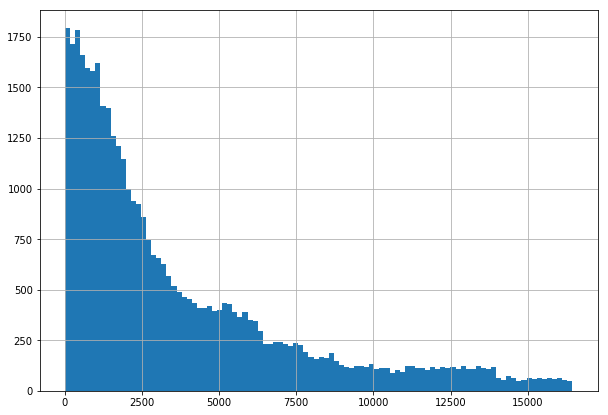

In [287]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

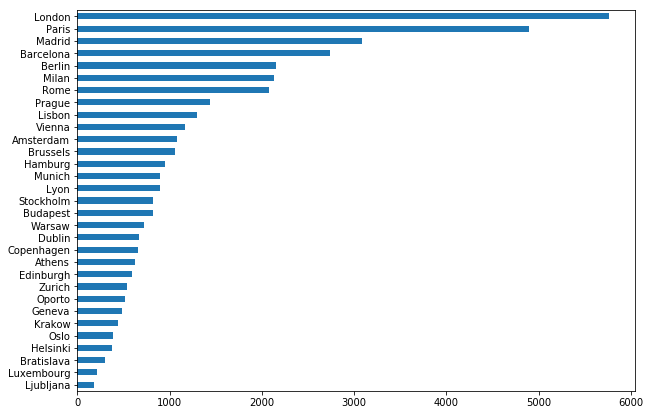

In [288]:
df_train['city'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

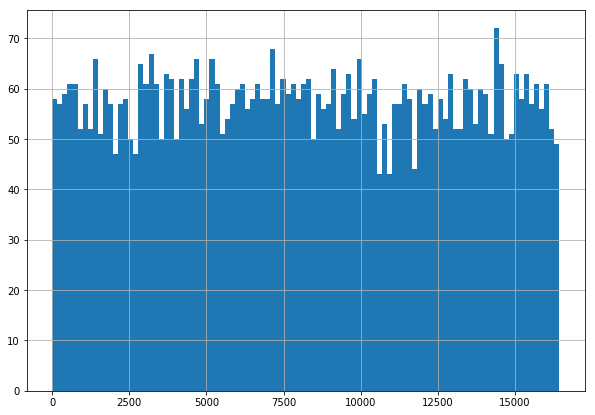

In [289]:
df_train['ranking'][df_train['city'] =='London'].hist(bins=100)

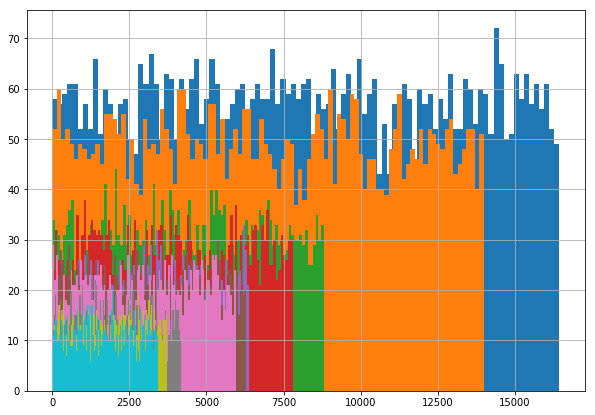

In [290]:
my.plot_big_cities_hist(df_train, 'ranking')

count    39980.000000
mean      3676.497249
std       3709.500590
min          1.000000
25%        973.000000
50%       2284.000000
75%       5261.000000
max      16444.000000
Name: ranking, dtype: float64

25-й перцентиль: 973.0, 75-й перцентиль: 5261.0 
IQR: 4288.0, Границы выбросов: [-5459.0, 11693.0].


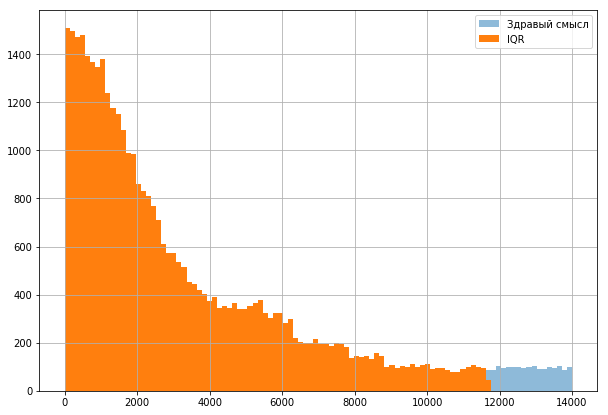

In [291]:
my.print_column_hist(df_train['ranking'], [1,14000])
my.preproc_ranking(df_train)
my.plot_big_cities_hist(df_train, 'ranking')

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


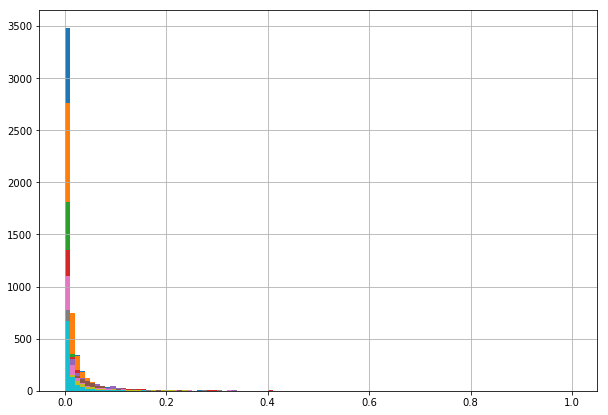

In [292]:
my.preproc_num_of_reviews(df_train)
my.plot_big_cities_hist(df_train[df_train['num_of_reviews'] > 0], 'num_of_reviews')

### Посмотрим распределение целевой переменной

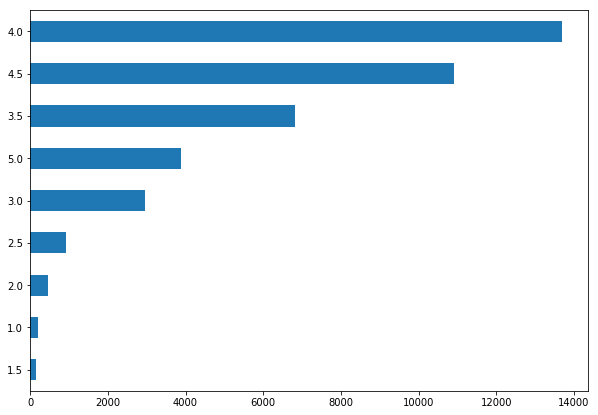

In [293]:
df_train['rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

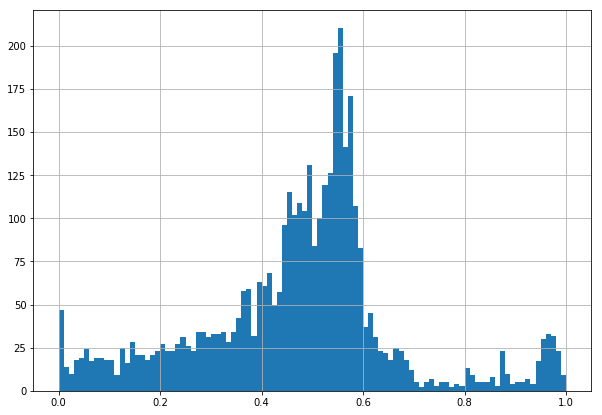

In [294]:
df_train['ranking'][df_train['rating'] == 5].hist(bins=100)

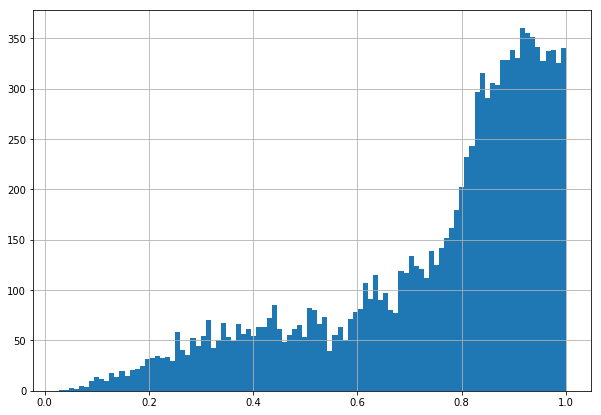

In [295]:
df_train['ranking'][df_train['rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

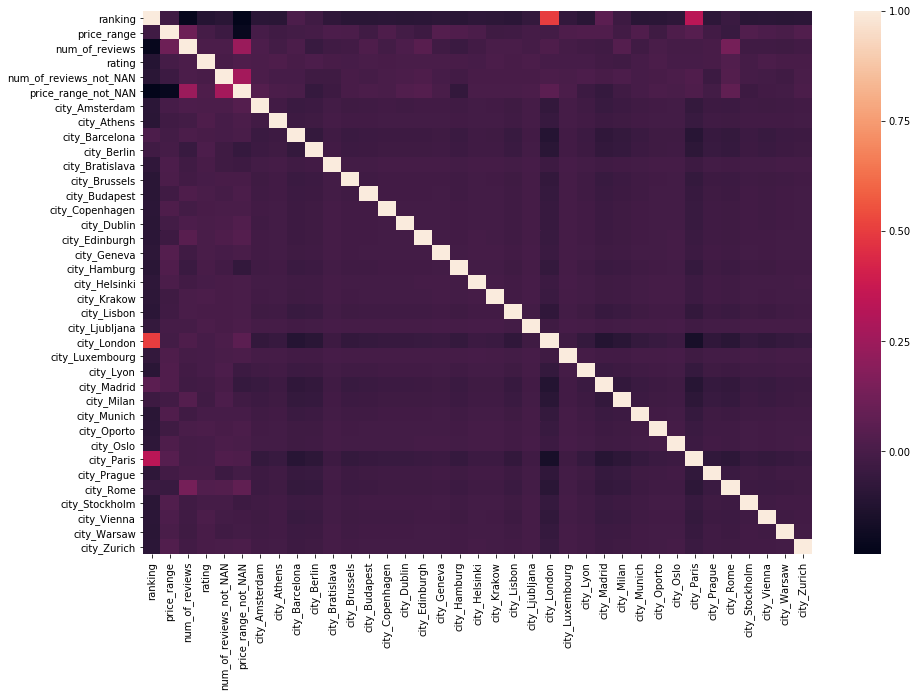

In [296]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [297]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')

df_train.columns = col_name_list
df_test.columns = [name for name in col_name_list if name != tgt_col_name]

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями


data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
rest_id           50000 non-null object
city              50000 non-null object
cuisine_style     38410 non-null object
ranking           50000 non-null float64
price_range       32639 non-null object
num_of_reviews    46800 non-null float64
reviews           49998 non-null object
url_ta            50000 non-null object
id_ta             50000 non-null object
sample            50000 non-null int64
rating            50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [298]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    train_idx = (df_output['sample'] == 1)
    df_train = df_output[train_idx]
    df_test = df_output[~train_idx]
    
    
    my.drop_id_ta_duplicates(df_train)
    df_output = df_test.append(df_train, sort=False).reset_index(drop=True)
    
    train_idx = (df_output['sample'] == 1)
    df_train = df_output[train_idx]
    df_test = df_output[~train_idx]
    my.print_unique_rest_info(df_train)
    
    my.align_id_ta_duplicates(df_output)
    my.print_id_ta_duplicates_info(df_output)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    # тут ваш код по обработке NAN
    
    my.clean_num_of_reviews(df_output)
    my.preproc_num_of_reviews(df_output)
    
    my.clean_price_range(df_output)
    my.preproc_price_range(df_output)
    
    my.clean_cuisine_style(df_output)
    my.preproc_cuisine_style(df_output)
    
    #df_output.loc[(df_output['ranking'] > 12e3) & (df_output['sample'] == 1), 'ranking'] = df_output.loc[~(df_output['ranking'] > 12e3) & (df_output['sample'] == 1), 'ranking'].mean()
    my.preproc_ranking(df_output)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = my.preproc_city(df_output)
    # df_output = pd.get_dummies(df_output, columns=[ 'city',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    df_output.drop(['rest_id','id_ta',], axis = 1, inplace=True)
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [299]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


{'Кол-во строк': 39980,
 'Кол-во уникальных по rest_id': 11907,
 'Кол-во уникальных по id_ta': 39980,
 'Кол-во уникальных по rest_id,city': 39980,
 'Кол-во уникальных по id_ta,city': 39980,
 'Кол-во уникальных по rest_id,city,id_ta': 39980}

d2669414     2
d5618007     2
d4748208     2
d2360290     2
d5617412     2
d3748757     2
d4914988     2
d12488993    2
d7827387     2
d3647024     2
Name: id_ta, dtype: int64

Кол-во дубликатов по id_ta: 17


'Макс уникальных'

[2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]

'Мин уникальных'

[2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2]

,ranking,price_range,num_of_reviews,sample,rating,num_of_reviews_not_NAN,price_range_not_NAN,cuisine_style_not_NAN,num_cuisine_style,cuisine_Vegetarian_Friendly,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
39070,0.411594,2,0.000639,1,5.0,1,1,1,2,0,...,1,0,0,0,0,0,0,0,0,0
2164,0.398417,2,0.018843,0,0.0,1,1,1,4,0,...,0,0,0,0,0,0,0,0,0,0
6357,0.106671,1,0.025387,0,0.0,1,1,1,6,0,...,0,0,0,0,0,0,0,0,0,0
18004,0.617178,2,0.005643,1,3.5,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
10686,0.911896,2,0.057574,1,3.0,1,1,1,2,0,...,0,0,0,0,0,0,1,0,0,0
7865,0.264023,2,0.011814,0,0.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
36747,0.653102,1,0.000560,1,5.0,1,1,1,2,0,...,0,0,0,0,0,1,0,0,0,0
30525,0.068540,2,0.023400,1,4.5,1,1,1,6,0,...,0,0,0,0,0,0,0,0,0,0
15674,0.427930,2,0.006808,1,4.5,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
10898,0.704598,2,0.001699,1,4.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [300]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49980 entries, 0 to 49979
Data columns (total 62 columns):
ranking                        49980 non-null float64
price_range                    49980 non-null uint8
num_of_reviews                 49980 non-null float64
sample                         49980 non-null int64
rating                         49980 non-null float64
num_of_reviews_not_NAN         49980 non-null uint8
price_range_not_NAN            49980 non-null uint8
cuisine_style_not_NAN          49980 non-null uint8
num_cuisine_style              49980 non-null uint8
cuisine_Vegetarian_Friendly    49980 non-null uint8
cuisine_European               49980 non-null uint8
cuisine_Other                  49980 non-null uint8
cuisine_Mediterranean          49980 non-null uint8
cuisine_Italian                49980 non-null uint8
cuisine_Vegan_Options          49980 non-null uint8
cuisine_Gluten_Free_Options    49980 non-null uint8
cuisine_Bar                    49980 non-null uint8
c

In [301]:
df_preproc['num_cuisine_style'].describe()

count    49980.000000
mean         2.625310
std          1.824117
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: num_cuisine_style, dtype: float64

In [302]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [303]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [304]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 61), (39980, 61), (39980, 60), (31984, 60), (7996, 60))

# Model 
Сам ML

In [305]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [306]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [307]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [308]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred),8))
mae_baseline = 0.21240125
print('MAE baseline:', mae_baseline)

MAE: 0.20880003
MAE baseline: 0.21240125


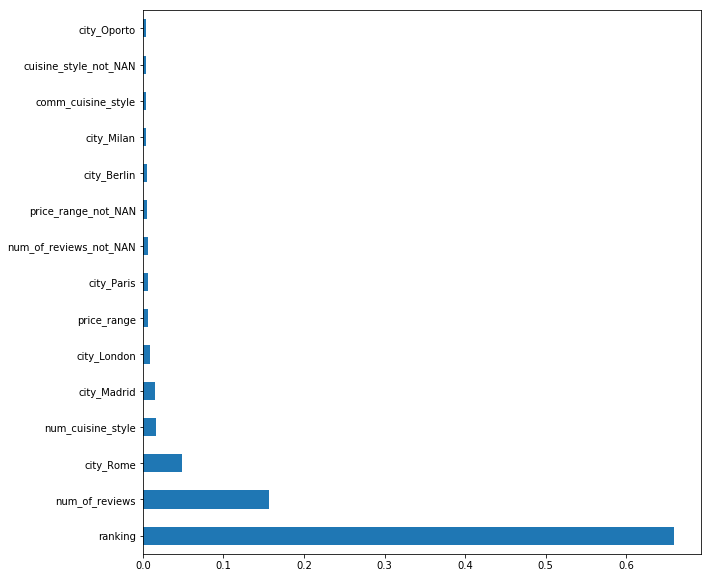

In [309]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [310]:
test_data.sample(10)

,ranking,price_range,num_of_reviews,rating,num_of_reviews_not_NAN,price_range_not_NAN,cuisine_style_not_NAN,num_cuisine_style,cuisine_Vegetarian_Friendly,cuisine_European,...,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
3183,0.832770,1,0.002362,0.0,1,1,1,6,0,0,...,0,0,0,0,0,0,0,0,0,0
9536,0.125581,2,0.027822,0.0,1,1,1,3,0,0,...,0,0,0,1,0,0,0,0,0,0
7045,0.155877,1,0.078768,0.0,1,1,1,2,0,0,...,0,0,0,0,0,1,0,0,0,0
8854,0.196803,2,0.007304,0.0,1,1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
5699,0.766091,2,0.003502,0.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2489,0.716013,2,0.000389,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7264,0.366144,2,0.023291,0.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
945,0.347350,2,0.006824,0.0,1,1,1,4,0,0,...,0,0,0,1,0,0,0,0,0,0
5206,0.779885,2,0.003775,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2438,0.882263,2,0.000295,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
test_data = test_data.drop(['rating'], axis=1)

In [312]:
sample_submission

,rest_id,rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [ ]:
# переобучим модель, используя train данные полностью
y = train_data.rating.values # наш таргет
X = train_data.drop(['rating'], axis=1)

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X, y)

In [313]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [314]:
predict_submission

array([3.35 , 4.12 , 4.395, ..., 3.03 , 4.48 , 4.28 ])

In [315]:
sample_submission['rating'] = predict_submission
sample_submission.rename(columns={'rest_id':'Restaurant_id'}, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,rating
0,id_0,3.350
1,id_1,4.120
2,id_2,4.395
3,id_3,4.400
4,id_4,4.490
5,id_5,4.405
6,id_6,1.140
7,id_7,3.515
8,id_8,4.460
9,id_9,4.745


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
